<sub>Mario Stanke, University of Greifswald, Germany</sub>
# Linear Regression Example
<sup>(a very special case of a neural network)</sup>

## Bike Sharing Demand
 - data set of *bike rental counts* in a Washington, D.C., bikeshare program 
 - extremely simplified data table with only
    - ```temp``` - temperature in Celsius
    - ```count``` - number of total rentals
    for individual hours during daytime and summer
 - **task**: predict bike rental demand (count of bikes) based on temperature
 - data source: [kaggle](https://www.kaggle.com/c/bike-sharing-demand)


In [1]:
import pandas as pd # for reading input table from file
import matplotlib.pyplot as plt # for plots
import numpy as np # for matrix computations
import tensorflow as tf # to compute gradients

/home/mario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mario/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [2]:
print(tf.__version__) # is this really at least version 2?

2.0.0-alpha0


In [3]:
# load the training data from the table file to a data frame
df = pd.read_csv("bikes-summerdays.tbl", sep='\s+')
print(df.head()) # show first lines as examples

# convert count data to floats as regression target
df['count'] = df['count'].astype(float) 
print(df.dtypes)

m, n_cols = df.shape # training set size and number of columns 
print("m = ", m, "\tn_cols = ", n_cols)

# compute average of hourly bike rental counts
meancount = np.mean(df['count'])
print ("mean bike count = ", meancount)

    temp  count
0  13.12    173
1  13.12     75
2  13.12     89
3  13.94     95
4  14.76    110
temp     float64
count    float64
dtype: object
m =  1482 	n_cols =  2
mean bike count =  311.0


### Make a first explorative plot

<IPython.core.display.Javascript object>


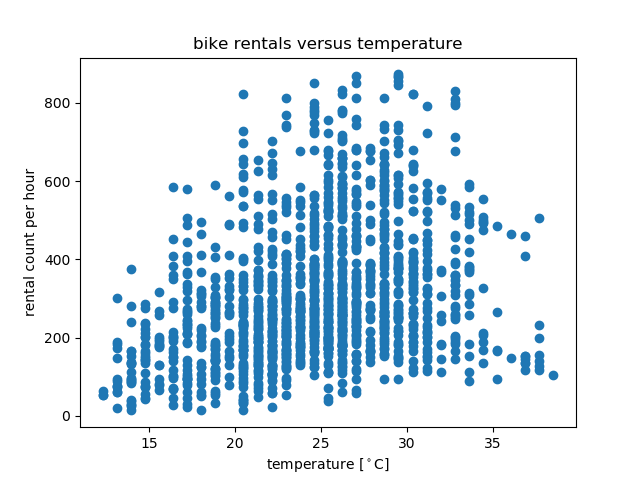

In [4]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(df["temp"], df["count"])
plt.title("bike rentals versus temperature")
plt.xlabel('temperature [' + r'$^\circ$' + 'C]')
plt.ylabel('rental count per hour');

In [5]:
# print summary statistics of temperature and rental counts during daytime in summer 
df.describe()

,temp,count
count,1482.000000,1482.000000
mean,24.612173,311.000000
std,4.979788,174.792339
min,12.300000,14.000000
25%,21.320000,184.000000
50%,24.600000,272.000000
75%,27.880000,398.750000
max,38.540000,873.000000


## Linear Regression

Input variables $x_1,\ldots, x_n$ (<span style="color:red">features</span>). Here: $n=1$ and $x_1=$ temperature.

Real valued output variable $y$ (aka <span style="color:red">response</span> variable). Here, $y=$ bike count.

### Hypothesis function
Let ${\bf x}=(x_1,\ldots, x_n)^T$ be an input vector and $\pmb{\theta}=(\theta_0,\theta_1,\ldots, \theta_n)^T$ be a vector of unknown coefficients (<span style="color:red">parameters</span>). The function

$$h_{\pmb{\theta}}({\bf x}) := \theta_0 + \theta_1 x_1 + \cdots \theta_n x_n$$

is called the <span style="color:red">hypothesis</span>.

**Aim**: Find parameters $\theta$ such that, roughly speaking,
$h_{\pmb{\theta}}({\bf x}) \approx y$
for most *examples* $({\bf x}, y)$ from a data set or data distribution.

### Data set
Let $m$ be the number of training examples (pairs of input/output), 

$${\bf X} := \begin{pmatrix}
1 & x^{(1)}_1 & x^{(1)}_2 & \cdots & x^{(1)}_n\\
\vdots & \vdots & \vdots & &\vdots\\ 
1 & x^{(m)}_1 & x^{(m)}_2 & \cdots & x^{(m)}_n\\
\end{pmatrix} = \left(x^{(i)}_j\right)_{\tiny\begin{array}{l}1\le i\le m\\ 0\le j \le n\end{array}
},$$

be the *data matrix*, where $x^{(i)}_j$ is the value of the $j$-th feature of the $i$-th example, $x_0^{(j)}:=1$, and 

$${\bf y} = \begin{pmatrix}y_1\\\vdots\\y_m\end{pmatrix}$$

be the vector of responses.


### Mean squared error function
Define the *mean squared error* function

$$\text{MSE}(\pmb{\theta}) = \frac{1}{m} ({\bf X} \pmb{\theta} - {\bf y})^2  
= \frac{1}{m} \sum_{i=1}^m (h_{\pmb{\theta}}({\bf x}^{(i)}) - y_i)^2 \qquad \qquad (1)$$

where the square is meant to be applied componentwise to a vector. In machine learning (ML), this is called a
<span style="color:red">loss function</span>. It is our target to be minimized:

$$ \text{MSE}(\pmb{\theta}) \to \min$$

## Create Data Matrix

In [6]:
n = n_cols - 1 # number of features

# extract response variable
if 'count' in df.columns:
    target = df.pop('count') # remove to-be-predicted variable from data frame
y = np.array(target.values)

temps = np.array(df.values) / 10 - 2.5 # normalize temperatures so they are roughly in [-1,1] 

# make data matrix X
X = np.ones((m, n+1))

X[:,1:n+1] = temps

# print first 5 examples
print(X[0:5,])
print(y[0:5])

[[ 1.    -1.188]
 [ 1.    -1.188]
 [ 1.    -1.188]
 [ 1.    -1.106]
 [ 1.    -1.024]]
[173.  75.  89.  95. 110.]


## Define Loss Function

In [7]:
# mean squared error loss function
def MSE(theta):
    """
        Mean squared error function for linear regression
        theta: numpy array, the first dimension must match the number of cols of X
               If theta is 2-dimensional, the output is 1-dim with one entry per col of theta.
    """
    if len(theta.shape) == 1:
        theta = tf.reshape(theta, (-1,1))
    # now theta is a matrix, but with a single column if theta is a vector
    yhat = tf.linalg.matmul(X, theta)
    d = (yhat - y.reshape((-1,1)))**2
    E = tf.reduce_sum(d, axis=0) / m
    return E

In [8]:
# two tests of calls to error function
print("single point:", MSE(np.array([1., 2.])))
print("two points: ", MSE(np.array([[1., 3.], [2., 4.]])))

single point: tf.Tensor([126566.30681717], shape=(1,), dtype=float64)
two points:  tf.Tensor([126566.30681717 125266.24137933], shape=(2,), dtype=float64)


<IPython.core.display.Javascript object>


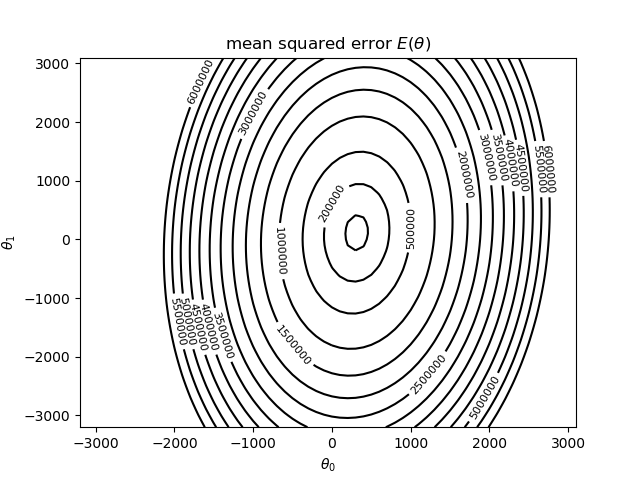

In [9]:
# code for plotting the "error landscape"
# this is for teaching purposes only and need not be read
def contourPlot():
    # compute error for the grid of all combinations of theta0 and theta1 values
    theta0 = theta1 = np.arange(-3200., 3200., 100) # grid axis ranges
    xv, yv = np.meshgrid(theta0, theta1) # x and y values of all grid points
    Theta = np.array([xv, yv]).reshape(2, -1) # 2 rows, one col per grid point

    # compute error for all grid points
    z = MSE(Theta).numpy()
    z = z.reshape((theta0.size,-1)) # make this a matrix again as required by contour

    ## make contour plot
    figC, axC = plt.subplots()
    # heights to draw contour lines for
    h = [50000, 200000] + list(range(500000, 6000001, 500000))
    contours = axC.contour(theta0, theta1, z, levels=h, colors='black')
    axC.clabel(contours, inline=True, fontsize=8, fmt='%i') # labels on lines
    plt.title("mean squared error " + r'$E(\theta)$');
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$');
    return axC

# TODO: how to make this interactive each time it is called?
axC = contourPlot() 

## Gradient and Gradient Descent

## Solution 1: Low-Level

In [10]:
def gradient_descent(theta_init, learning_rate):
    N = 100 # number of update steps
    alpha = learning_rate; # learning rate
    
    # create variable for model parameters (weights)
    # and initialize it
    theta = tf.Variable(theta_init, dtype=tf.float64, name="weights", trainable=True)
    # a better starting value for theta would be [[meancount], [0]]
    
    # variable to monitor progress
    err = np.zeros(N + 1) # error after each update step
    Theta = np.zeros((2, N + 1)) # sequence of parameters
    
    # initialize variables to monitor
    err[0] = MSE(theta) # initial mean squared error
    Theta[:, 0] = theta_init # initial parameters

    # simple gradient descent loop
    for i in range(1, N + 1):
        with tf.GradientTape() as tape:
            # tape.watch(theta)
            E = MSE(theta)
        
        grad = tape.gradient(E, theta) # let tf compute the derivate of E wrt to theta
        theta.assign(theta - alpha * grad)
        Theta[:, i] = theta.numpy()
        err[i] = E.numpy().squeeze()
        if (i%10 == 0):
            print ("error after ", i, " iterations: ", err[i], " gradient= ", grad.numpy())
    return [Theta, err]

## Visualization of Optimization Progress

In [15]:
def plot_progress(Theta, err, col):
    # plot error over time
    fig, ax = plt.subplots()
    plt.plot(np.log(err), 'o-', color=col, linewidth=.2, markersize=3, mfc='none')
    plt.title("log training error by iteration of gradient descent")
    plt.xlabel('iteration '+r'$i$')
    plt.ylabel(r'$ln \;E(\theta^{(i)})$');

    # plot parameters over time
    axC = contourPlot()
    plt.plot(Theta[0, 0], Theta[1, 0], 'o', color='green', mfc='none') # mark starting point with circle
    ymin, ymax = axC.get_ylim()
    xmin, xmax = axC.get_xlim()
    for i in range(1, Theta.shape[1]):
        if (np.abs(Theta[0, i] - Theta[0, i-1]) + np.abs(Theta[1, i] - Theta[1, i-1]) > 1e-6):
            # above condition avoids arrows with a length that is practically 0
            plt.arrow(Theta[0, i-1], Theta[1, i-1], Theta[0, i] - Theta[0, i-1], Theta[1, i] - Theta[1, i-1],
                      color=col, width=5, head_length=60, head_width=80, overhang=.9, length_includes_head=True)

### A successful run of gradient descent

error after  10  iterations:  229577.57608591864  gradient=  [ 28.91159139 446.51542535]
error after  20  iterations:  41662.773963201944  gradient=  [  6.15575172 119.35852472]
error after  30  iterations:  28254.06473966989  gradient=  [ 1.64288693 31.8843458 ]
error after  40  iterations:  27297.23866164813  gradient=  [0.4388633  8.51727226]
error after  50  iterations:  27228.96093790433  gradient=  [0.11723365 2.27522078]
error after  60  iterations:  27224.08873838268  gradient=  [0.03131665 0.60778022]
error after  70  iterations:  27223.74106527824  gradient=  [0.00836562 0.16235646]
error after  80  iterations:  27223.71625582883  gradient=  [0.00223471 0.04337032]
error after  90  iterations:  27223.714485462442  gradient=  [0.00059696 0.01158552]
error after  100  iterations:  27223.71435913166  gradient=  [0.00015947 0.00309484]
theta after optimization:  [315.48111677 115.54233945]


<IPython.core.display.Javascript object>


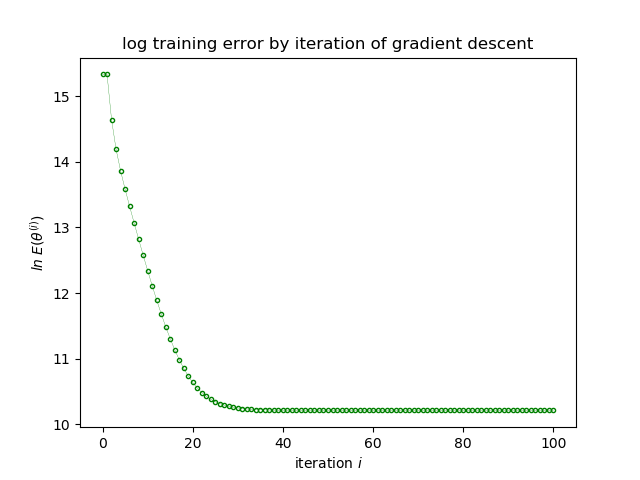

<IPython.core.display.Javascript object>


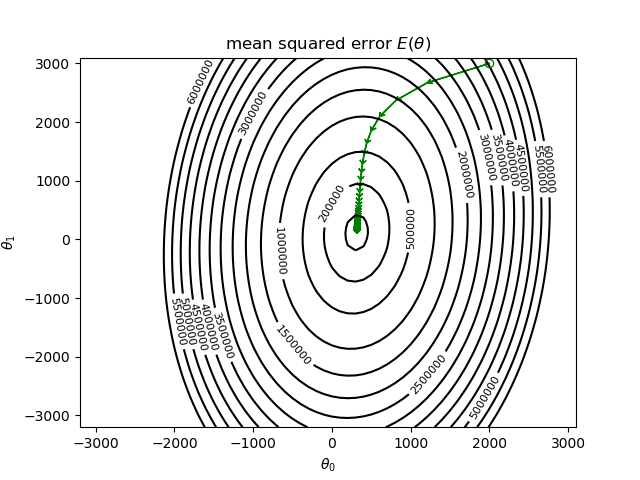

In [19]:
[Theta1, err1] = gradient_descent(np.array([2000., 3000.]), learning_rate=0.25) 
print("theta after optimization: ", Theta1[:,-1])
plot_progress(Theta1, err1, col='green')

### An <span style="color:red">unsuccessful</span> run of gradient descent

error after  10  iterations:  3682450.9366226587  gradient=  [-3822.63748504   193.74563642]
error after  20  iterations:  3985977.4528556564  gradient=  [-3978.0203884    204.96906715]
error after  30  iterations:  4314720.781832481  gradient=  [-4139.89817946   213.31352152]
error after  40  iterations:  4670763.65595478  gradient=  [-4308.36346624   221.99391373]
error after  50  iterations:  5056373.087492278  gradient=  [-4483.68412783   231.02753407]
error after  60  iterations:  5474004.346247928  gradient=  [-4666.13913048   240.42876042]
error after  70  iterations:  5926316.592850386  gradient=  [-4856.01879265   250.2125518 ]
error after  80  iterations:  6416189.810281848  gradient=  [-5053.62524672   260.39447597]
error after  90  iterations:  6946743.14143571  gradient=  [-5259.27291982   270.99073419]
error after  100  iterations:  7521354.749464376  gradient=  [-5473.28903407   282.018187  ]
theta after optimization:  [3057.58316183  -25.7534577 ]


<IPython.core.display.Javascript object>


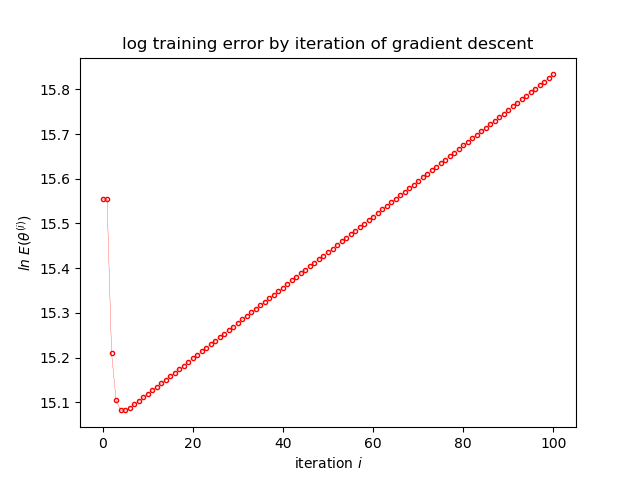

<IPython.core.display.Javascript object>


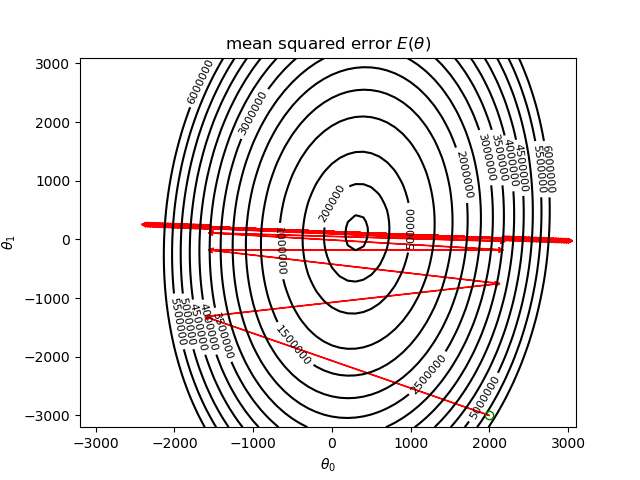

In [21]:
[Theta2, err2] = gradient_descent(np.array([2000, -3000]), learning_rate=1.0) # but: success with lr .99 
print("theta after optimization: ", Theta2[:,-1])
plot_progress(Theta2, err2, col='red')

## Solution 2: High-Level
This approach is recommended for most applications using previously defined model classes.


In [22]:
optimizer = tf.keras.optimizers.SGD(learning_rate=.25)
# SGD: stochastic gradient descent
loss_object = tf.keras.losses.MeanSquaredError()
# this is MSE function defined in equation (1)

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))
# a tf.data.Dataset has commonly used functions for random sampling, obtaining subsets
# iterating over large numbers of images on disk (using TFRecord)
dataset = dataset.shuffle(m).batch(m) # random order, use whole dataset as 'batch' for comparability
# Normally, the batch size would be smaller, e.g. 32.

In [25]:
# Get a predefined linear model with one single output variable and one weight per input.
# We initialize theta with [2000, 3000] for comparability only.
# More common and default is random initialization.
model = tf.keras.layers.Dense(1, use_bias = False, # bias would be redundant due to the column of ones
                              kernel_initializer = tf.constant_initializer([2000, 3000]))


In [27]:
# one gradient descent step
def train_step(features, temp):
    with tf.GradientTape() as tape:
        pred = model(features)
        pred = tf.reshape(pred, [-1])
        E = loss_object(temp, pred)

    grads = tape.gradient(E, model.trainable_variables)
    # this makes a parameter update using the gradient
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return E

In [30]:
for epoch in range(100):
    # loop over batches of dataset
    # Here it is here just a single big batch for comparability with Solution 1.
    for (batch, (f, t)) in enumerate(dataset):
        # batch: running nr
        # f: batch features of shape (batch_size, 2)
        # t: batch labels
        E = train_step(f, t)

In [32]:
# final loss computed on all training data
pred = model(X)
pred = tf.reshape(pred, [m])
E = loss_object(y, pred)
print("final error = ", E.numpy())
print(model.trainable_variables[0].numpy())

final error =  27223.71484375
[[315.48083425]
 [115.53685645]]
